# Overview

The field of version control has been evolving since the early 60's. Recently, as data science, machine learning, and artificial inteligence (all data based applciations), take off, the need to maintain control over data sets is beginning to surface and grow. Additionally, the expectation that [databases evolve](https://martinfowler.com/articles/evodb.html) is also merging with the devops ideology.

Currently, the application of version control to data is relatively new. While there are several options on the market, many are not fully featured yet.

In this article we will
1. Review the use cases for data version control systems (DVCS)
2. Review the types of data that need versioning
3. Define the full set of features one would expect from a VCS for data 
4. Review the current offerings on the market

# What Is A Traditional Version Control System (VCS)?
Before diving into DVCS it's imperative that the reader understand traditional version control. This is because VCS is the foundation of all scalable DevOps implimentations. It informs all process architecture and release strategies. As Such, DVCS closely follows and extends the VCS concepts. In doing so it is directly compatible with the DevOps mindset and workflow and can be adopted without major issues.

So what is version control? Generally speaking version control is the practice of tracking the evolution of a code base over time. VCS tooling is able to serve the user historical and current versions and compare and track changes through the evolutionary timeline. It also allows multiple engineers to safely work in parallel and provide governance.

The major elements of successful version control implimentations are built around four pillars:

- Branching Strategy - The process by which changes are made, reviewed, and approved by the development team.
- Versioning Strategy - The process by which arbitrary changes are comitted and named.
- Promotion Strategy - The process by which versions of a software solution are associated with a quality tier.
- Deployment Strategy - The process by which a given version of a specific quality tier is delivered to a target environment.

Fully defining these concepts is a conversation of their own. The nuances are not necessarily required for this topic. Simply recognizing the parallels is required.

## Branching Strategies
In a VCS, a branch is a sequential set of commits. Commits are immutable snapshots of the state of a code repository at a given point in time.

There are many branching strategies used in practice. These strategies can be classified by the number of integration branches, non integration branches, merge policies, and quality tiers. 

### Trunk Based Development

We will consider the most basic strategy: Trunk Based Development. The workflow however applies to all strategies as they are all derived from this model. Below we see a branch-flow diagram.

<center><img src="images/dvcs-branching-workflow.png"></center>

## Versioning Strategies

The process by which arbitrary changes are comitted and named. Through the versioning strategy we understand logically/philisophically how a version is created as well as tangibly what we will call this thing. 

For example we might have a new version called "birthday code" which i wrote on my birthday. We might have a version coming our every 3 hours and name them based on our favorite baseball player. We might have a version called v2 which is so different from v1 such that it is incompatible.

There are many versioning strategies, we will look at CalVer.

### Calendar Versioning (CalVer)
A popular versioningstrategy is [Calendar Versioning (CalVer)](https://calver.org/). With this strategy a version number is broken down into several fields, each of which contain information about the version.

## Promotion Strategies

Promotion Strategies articulate quality gates; they define how code is promoted from one quality level to a higher quality level by crossing through a quality gate which is enforced programatically. Typically the gate is implimented as an automated test suite. Before the given version number can be attached to a specific commit it must run a series of tests that guarantee there are no problems and the quality standards are upheld (i.e. no bugs).

## Deployment Strategies
Deployment Strategies dictate what environment a specific version of code will be deployed to. Typically quality tiers are mapped to environment tiers such that code can only be deployed to an environment with an associated quality tier that is equal to or below the given version of code. For example, production quality code can be deployed to prod and non-prod environments while non-prod code can only target non-prod environments.

## Summary

The four pillars discussed above allow for a successful VCS implimentation. These pillars will also apply to version control for data as that problem space faces many of the same issues.

# What Is A Data Version Control System (DVCS)?

In short, a DVCS is the data analog of traditional VCS. It's a version control system applied to data. Similar to code data versions are logical abstractions representing discrete changes; in this case to a data set.

## So how would we employ DVCS?

To answer this question we need to answer the following questions:
- What constitutes a new version of data? 
- How does one version change from the next?
- How do I switch from one version to the next?
- Who is authorized to create a version?

A new version could occur every with every new transaction applied to the data store. When a major schema change occurs rendering a dataset incompatible with downstream codebases. A version could also signify the omission of a transaction: e.g. maintaining versions with and without personally identifying information (PII).

This information is articulated through the branching and versioning strategies.

The end goal is to provide data versioning, data lineage, and successfully execute a branching strategy for the purposes of continuous integration. The process of continuous integration provides process synchronization, quality gates, and serves as the backbone of data governance and continuous deployment.

## Use cases for DVCS


Tracking Temporal Data

- Time series data

Tracking evolution of the data set

- Adhoc corrections need to be made to the data
- New or experimental code that performs modifications is being run against a data set

Unlocking rapid / agile development

- Parallel development that introduces breaking changes

Protection

- Bug in an application causes corruption
- Malicious actor makes unauthorized modifications

# 2. Types of Data
Before talking about the various VCS options for data we need to understand that data comes in different formats and there likely isn't going to be a single robust solution that accomodates all data types.

Data typically comes in the following flavors:
1. Files / Filesystems
    1. Tables
    2. JSON
2. Objects
3. Raw Block Devices
4. Databases

Now that we understand the basic types of data, lets understand the typical features that version control systems offer.

# 3. Features Of A DVCS

## 3.1. Core Features

- **History** - An immutable sequential set of point-in-time representations (often referred to as commits) of a data set. I.e. A representation of the historical evolution of a data set.

- **Lineage (provenance)** - An imutable ancenstral representation of the inputs and processes that produced a given commit, commit history, or change. 

    For example, if a pipeline is responsible for adding a new row or if a user is responsible for modifying a file, this information would be captured and reviewable.

- **Braching** - An ability to represent and reference discrete parallel states of a data set for a single point in time.

- **Merging** The ability to combine parallel commit histories into a single commit history by accepting changes from both version histories and accepting and combining changes to individual files; the abiity to define and impliment merge strategies.

- **Conflict Detection and Resolution** - The ability to detect and remediate istances of merge conflicts (when changes in two branches are incompatible or contradict eachother). This functionality, like with diffing, may be offloaded in part to the underlying storage layer or an established third party tool.

- **Data Efficiency** - The ability to minimize the number of redundant copies of data.

    Storing data costs money, and with big data you will see big costs. The DVSC should be able to allow multiple branches or commits to reference the same copy of data without requiring a separate copy for each observer.

- **Atomicity** - The version history is composed of atomic (invivisible and irreducible) units of change. The operations performed on the version history are also atomic guaranteeing that updates to are either successful or in innert in the case of failure. Additionally no two operations can be performed at the same time; only one update to a version history can occur at a given time.

- **Persistance**: The ability for the data managed by the VCS to survive system power loss. The data should be stored in a persistant data store.

- **Durability**: The ability for version history and linage to survive corruption events (such as transaction failures or bit-rot). The VCS should impliment or inherit mechanisms to prevent against corruption and possible unintended data loss.

- **Retention**: The ability to define which set or subset of version history events to "forget" or erase based on some predefined policy. While the VCS must be able to persist all records of data changes, in some cases, the user may prefer only to retain a rolling window of changes. It's also possible that the user may want to specify an alternate retention strategy. The VCS should support the ability to prune its records of versions that are no longer needed or wanted. 

    Note: The underlying storage layer may impliment it's own retention policy. If the VCS is built on top of a 3rd party datastore this may interfere with the retention policy of the VCS depending on the implimentation.

- **Working Set** - A mutable copy of a commit or an unstracked data set intended to be comitted at a later date.

- **Reversion**: The ability to restore a working set or branch to a historical version. This reversion should support reverting the data in whole or in part (i.e. a single file or an entire directory).

- **Metadata Support** - The VCS should allow the user to attach meaningful information to the changes being recorded in the system (i.e. what were the changes, why where they made, etc.). With traditional VCS we are able to see the user who comitted the, a description of the change, and a change list associated with the commit. Data pipelines however are a bit more complicated and robust than human driven edits to plain text files. For example, data may be transformed through a DAG expressed through a pipeline or by a transformation as part of a stream. In both of these instances the transformation is implimented via an instance of code. The VCS should be aware of the process which is orchestrating and/or applying a particular change to a data set. For example if there is a pipeline run the VCS should be able to create a link between the verson of code and the instance of the pipeline which performed the transaction. This additional 

- **Diffing**: The ability to show the differences between commits, between a working set and a commit, or individual files rather than the entire data set. 

   In practice, Some of this functionality can be offloaded in part to the underlying storage implimentation. For example, if a JSON file changed, there are already diff tools which can compare plain text files; if a database file changed, one may need to leverage the underlying database tooling to do a comparison.

- **Reviewability** - The ability to review and query metadata attached to the revisions in the history. 

- **Format Aignostic** - Able to support multiple formats or types of data (eg. text files, binary files, database files).

- **Blame Support** - Similar to traditional VCS the DVCS should allow a user to identify who is responsible for a particular change in the data.

- **Role Based Access Control** - The VCS needs to be able to define users, roles, and associated permissions. While the underlying storage layer will have it's own RBAC, which should be respected by the VCS implimentation, the VCS maintains its own objects and data which also must be protected.

## 3.2. Operational Features

- **Backup Support**: The VCS system needs to enable system admins to perform backups. As such a copy of the entire system can be snapshotted and archived for disaster recovery purposes.

- **Resilliance** - As with a datastore, the VCS should be able to recover from failures and provide an uninterrupted service to the users.

- **Scalability** - The VCS performance should not be impacted with changes to the size of the underlying data set or the length of the revision history.

## 3.3. Architectural Features

- **Datastore Integration**: The VCS should be built on top of an established traditional storage layers. In doing so, the VCS will minimize the complexity of it's design and maximize the utility provided to users and admins.

- **Highest Level Abstraction**: speaking in the abstract, data is stored in containers (sometimes in a nested or hierachical structure). For example, sql data is stored in a table in a database; json files are stored in an S3 bucket in an AWS account. The VCS should be aware of the abstractions provided by the underlying data stores. It should be able to understand and register changes to any multiple of lower abstraction within the data store. As such, the DVCS should provide an abstraction that can sit above any other "layer" representing a data source.

# 4. Reference Architecture

Currently there are no solutions which are feature complete. There are a number of solutions which offer a subset of the features specified above. In this section I propose a reference architecture and talk through how several solutions fit into that architecture.

## 4.1. Overview

Below we can see a modular solution designed to conform to the client-server model. The DVCS solution sits on top of the underlying storage layer and proxies native traffic to the underlying datastore.

<center><img src="images/dvcs-architecture-diagram.png" style="width: 400px"></center>

With this architecture the client connects to the DVCS to provide administrative commands to the DVCS repository,  informative metadata about the lineage of a particular state of the DVCS repository, or to connect to the underlying datastore to manipulate the actual data.

## 4.2. Components

### 4.2.1. The Storage Layer Proxy (SLP)

The SLP is a metered/monitored proxy which is responsible for connecting a client directly to their data which is stored on the underlying storage layer. The location of the actual data is based on the input from the VCL. The data could "move around" as different VCS event occur. For example, if we want to access a file from a particular version of the repository, there may be some underlying magic that needs to happen so that I can read that file while someone else reads a newer copy. The SLP informs the LCL of client session activity through the metadata store. As clients establish connections and perform operations, the SLP can observe and report.

### 4.2.2. The Lineage Control Layer (LCL)
The LCL is responsible for tracking the lineage of the VCS events; such as where the data is from and what transformations are responsible for creating the data associated with a given commit. When clients connect to the DVCS they establish a session and are given access to the underlying data store through a metered proxy (the SLP). Any storage layer transactions declared/observed are tied to the respective client and catalogued.

### 4.2.3 The Version Control Layer

The VCL is responsible for managing the commit history, the commit metadata, and the working set. It manipulates the underlying storage layer to snapshot data, create working copies, and provide diff functionality. It configures the storage layer proxy to direct client requests to a respective underlying data store.

### 4.2.4. The Storage Layer
The storage layer is the technology the user has elected to store their raw data. This would be a solution that provides file, object, block, or database storage. The storage layer is managed by the DVCS which sits above it. User traffic is directed to the storage layer through the DVCS and its SLP.

### 4.2.5. The Metadata Store
The metadata store is responsible for storing metadata related to the version history, version lineage, proxy settings, and event hooks associated with a data repository.

### 4.2.6. Event Hooks & Compute
The event hook system allows sub systems to trigger events. Internal and 3rd party systems are able to register event hooks to execute when a specified events occur. For example, when the underlying storage layer triggers an event, the event hook system can witness the event and notify downstream systems. The Event Hook functionality requires a compute layer to host execution of the registered callbacks.

## 4.3. Workflow

The basic process of using a DVCS is analogous to the process of using a traditional VCS. The end goal is to provide data versioning, data lineage, and successfully execute a branching strategy for the purposes of continuous integration. The process of continuous integration provides process synchronization, quality gates, and serves as the backbone of data governance and continuous deployment.




The basic process of adding new data to the central repository is as follows:

1. Create Repo
1. Create Initial Commit & Integration Branch
1. Create Branch
1. Make Commit(s)
    - Update Working Set (through human or pipeline)
    - Commit Changes
1. Merge Into Integration Branch


### 4.3.3. Merging Strategy

This branching proceedure should work in both real-time streaming and batch data processing scenarios. 

There is a tradeoff that exists however between data availability and the merge activity; technically, data is not "official" until it is comitted/merged into the target branch. In the event that data exists in the working set (uncomitted changes) of an non-integration branch, the data   

In this case of integration branches, there are not direct commits, which means data is not present until it is merged.

real time streaming vs streaming

The real challenge that needs to be addressed is the process of merging in the event of a conflict.


There may need to be minor rearchitecting to facilitate the streaming processes

With respect to streaming data there is a small hitch with respect to  discretization.













Walk through branching strategy and lineage for db, file store, and rbd. Discuss how atomic operations happen.
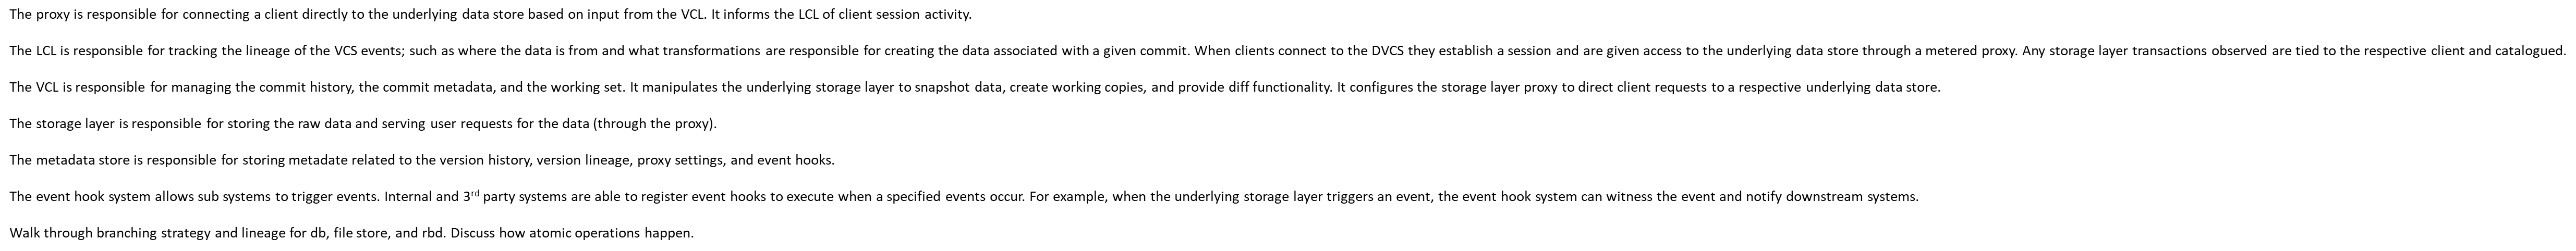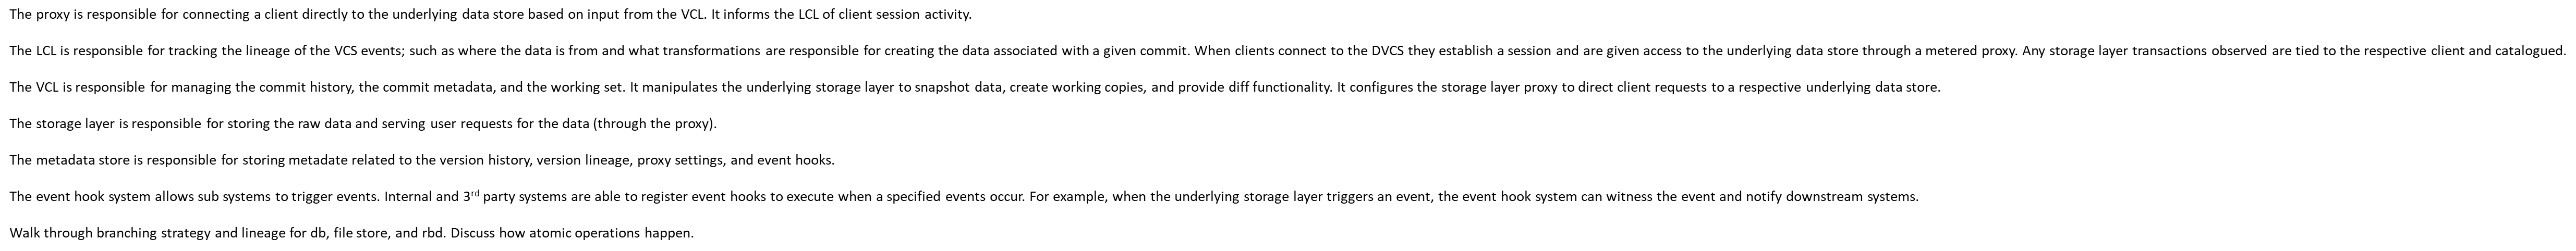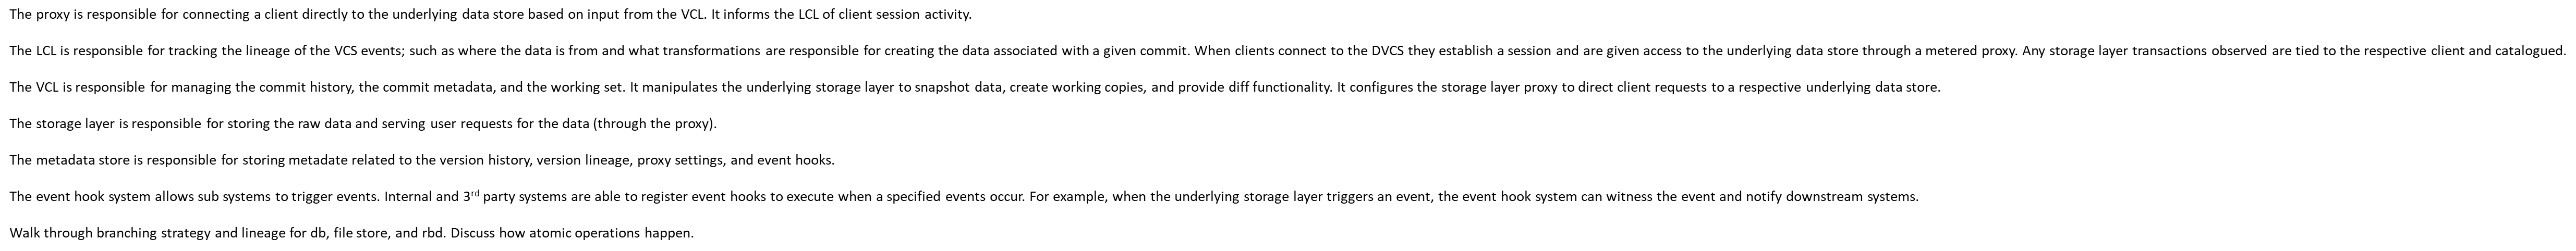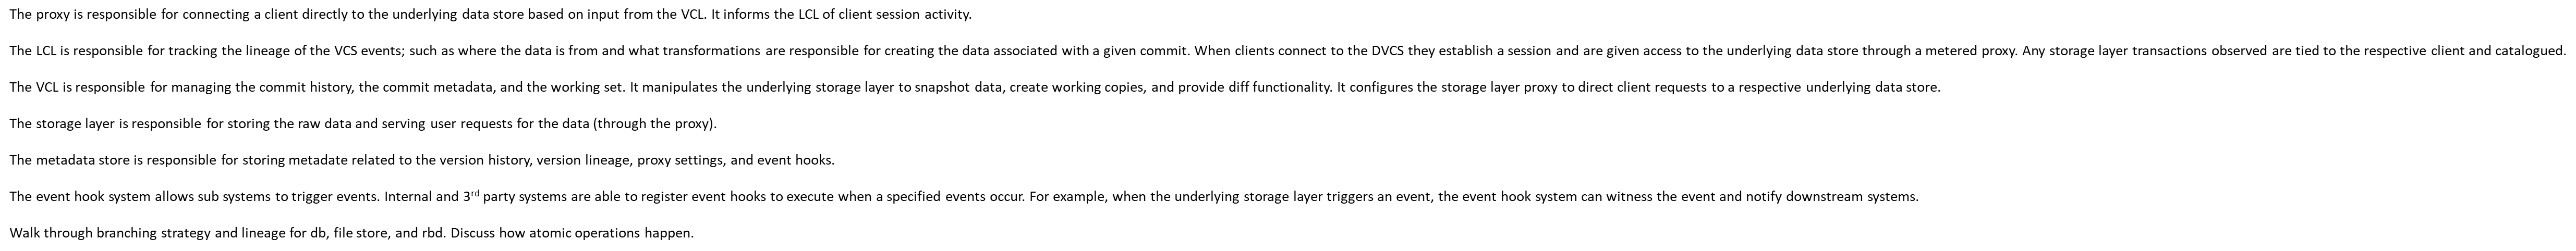

# 4. Current Market Solutions

## 1.1. The Classic DIY Approach
The classical approach has been for DBA's and system admins to maintain their own mechanisms for managing the various versions of a data set as it evolves over time. These solutions are generally built on top of the datastore, consists of a patchwork of code and 3rd party solutions, and impliment only a subset of features expected of a DVCS.

Generally speaking there are two methods used in parallel:
1. Taking system "snapshots" or backups (of the entire system or enough to rebuild the system manually) periodically via automation or manual efforts
2. Integrating versioning metadata into the underlying schema of the data. This can be done by injecting information into file names or table names (eg. my_file_20203_v2 or my_table becomes my_table_2022 or mytable_v1).

But these approaches don't provide all the functionality that a robust VCS would provide

### 1.1.1. Example Using MS SQL Server

https://blog.devart.com/database-versioning-with-examples.html

### 1.1.2. "As Of" Syntax
We have SQL "as of" syntax. This is in the SQL standard as of 2011 (pun intended) and supported by Oracle, Microsoft SQL Server, and MariaDB. With this syntax you can configure a table to be versioned or a "temporal table" and then query a version using as of <timestamp>. You don't get diffs and merges but you do get instant rollbacks.

## 1.2. Solutions For Popular Databases

Martin Fowler wrote this [article on Evolutionary Database Design](https://martinfowler.com/articles/evodb.html) outlining some of the problems and features one would expect. Some of the solutions below address the issues and designs being proposed.

In general, when we talk about applying version control to a database, holistically we are talkign about all the elements of a database including:
- Database Schema
- Database Object Definitions
- Database Data
- Database RBAC (roles, privileges, etc.)

As we may have infered from the custom built solutions section, we may need to apply a different tool / technique to each component of the database. Below we look at examples that try to capture many/all of these elements in one solution.

### 1.2.1. Dolt (MySql Databases)

Dolt is a MySQL database that impliments a git-like api which provides version control for tables and table rows.

According to it's homepage: 
> Dolt is the first  and only SQL database that you can fork, clone, branch, merge, push and pull just like a Git repository. Dolt is a version controlled database. Dolt is Git for Data. Dolt is a Versioned MySQL Replica.
> 
> Dolt implements the Git command line and associated operations on table rows instead of files. Data and schema are modified in the working set using SQL. When you want to permanently store a version of the working set, you make a commit. In SQL, Dolt implements Git read operations (ie. diff, log) as system tables and write operations (ie. commit, merge) as stored procedures. Dolt produces cell-wise diffs and merges, making data debugging between versions tractable. Dolt is the only SQL database that has branches and merges.
>
>You can run Dolt online, like you would PostgreSQL or MySQL. Or you can run Dolt offline, treating data and schema like source code.
>
> https://docs.dolthub.com/introduction/what-is-dolt

With the addition of its support for MySql/MariaDB Binlog replication, Dolt can be attached to a primary database and can provider versioning for this primary replica.

Dolt handles write operations through stored procedures and will present the difference between data versions cell-wise. For more information we can see the [following article](https://cult.honeypot.io/reads/dolt-a-sql-database-that-works-like-git).

### 1.2.2. VersionSQL (MS SQL Server)

VersionSQL is a plugin for the SQL Server Management Studio IDE. It allows DBA's to track and version changes to database code files from the SSMS interface. The plugin connects to remote VCS systems like Github.

https://www.versionsql.com/sql-server-database/

This may work for other databases like MySQL as SSMS is able to connect to multiple servers. https://docs.devart.com/odbc/mysql/microsoft_sql_server_manager_s.htm


## 2.3. Solutions For File Data

### Git-LFS
Git Large File Storage (LFS) replaces large files such as audio samples, videos, datasets, and graphics with text pointers inside Git, while storing the file contents on a remote server implimenting the git-lfs protocol (like GitHub.com or GitHub Enterprise).

This issues with git-lfs is that like git, it uses the client server model. This means there is a local copy of the data and a remote copy, and these need to be synchronized. This will not scale well when the data store starts reaching a massive size or a massive file count. Copying down terrabytes of information or even monitoring / managing that footprint will not scale well on a single machine. Additionally, this model also creates a potential bottleneck and it requires the user to operate on top of a POSIX api. 

To mitigate the issue of having to sync to and from the server, the user could elect to use a networked filesystem (like ceph) and mount it rather than working off of a local filesystem. This would provide a scalabile mechanism for sync'ing the data. But it would not resolve the issue of concurrency: multiple users would be pointing at the same branch. Some networked file systems have the ability to create subvolumes or atomic layers or branches. These subvolumes can be independently mounted. In this way we could provide the ability for multiple users to work independently, in parallel, on their own forked copies of the data.

https://git-lfs.com/

### Git-annex

[Git-annex](https://git-annex.branchable.com/) is similar to git-lfs; allows managing large files with git, without storing the file contents in git. It is an older solution than git-lfs and supports a wide number of backends as opposed to git-lfs which only supports a git-lfs backend. That being said, it has some quarks between windows and linux use cases. More information on the differences can be found [here](https://stackoverflow.com/questions/39337586/how-do-git-lfs-and-git-annex-differ) and [here](https://www.perforce.com/manuals/gitswarm-ee/workflow/lfs/migrate_from_git_annex_to_git_lfs.html).

### DVC

DVC stands for (Not Just) Data Version Control. The reason for this is that DVC offers versioning for the entire data science and machine learning workflow. It's homepage can be found [here](https://dvc.org/). It bosts that DVC can version source code, data, machine learning experiemtns, and machine learning models. These later features will be left for another article discussing those topics. 

With respect to versioning data, DVC is alot like git-lfs and it integrates directly with git. The basic function is to tell git to ignore a data directory and to tell dvc to track that data directory. DVC will add files tothe git repository that act as pointer to the actual data. The DVC command line is very similar to git meaining the concepts of branches, staging, commits, push, and pull still apply.

One of the advantages of git-lfs is that DVC is able to store data in a larger array of backen storage repositories. DVC supports Amazon S3, Microsoft Azure Blob Storage, Google Drive, Google Cloud Storage, Aliyun OSS, SSH/SFTP, HDFS, HTTP, network-attached storage, or disc to store file contents.

A helpful walkthrough can be found [here](https://towardsdatascience.com/introduction-to-dvc-data-version-control-tool-for-machine-learning-projects-7cb49c229fe0).


Note: DVC will face similar issue to git-lfs and thus can use a similar workaround as the one mentioned in that section.

Another scalability limitation is that users note that the system slows down as the number of files being tracked grows. This is because the solution is a program that runs on a single compute footprint. It is not distributed.

### Hangar
A python package which impliments the DVC functionality. More information can be found [here](https://opendatascience.com/introduction-to-data-version-control/).

### LakeFS
LakeFS is a git-like solution that sits on top of S3 (azure support is on the roadmap). It works by providing a metadata layer on top of the "real files". It keeps track of which "real files" are part of which version as well as what operations were performed between versions. This is very nice because there is no data duplication and no client/server that you might see with git-lfs or DVC.

For more information on LakeFS see [this article](./LakeFS/Intro%20To%20LakeFS.ipynb)

### Pachyderm
Pachyderm is provides a DVCS implimentaion that provides functionality analogous to a minimal git implimentation; users can commit and branch the data repositories. The solution itself is hosted on kubernetes and can be deployed on cloud or on-prem. The solution has a community and enterprise edition available.

The official documentation can be found [here](https://docs.pachyderm.com/latest/overview/). I explore this solution in the following [notebook](Pachyderm/Intro%20To%20Pachyderm.ipynb).

### Deep Lake (Formerly Activeloop Hub)

Deep Lake is a data lake implimentation designed for deep learning. According to the documentation:

> Deep Lake (formerly known as Activeloop Hub) is a data lake for deep learning applications. Our open-source dataset format is optimized for rapid streaming and querying of data while training models at scale, and it includes a simple API for creating, storing, and collaborating on AI datasets of any size. It can be deployed locally or in the cloud, and it enables you to store all of your data in one place, ranging from simple annotations to large videos.
> 
> https://github.com/activeloopai/deeplake

Looking through the [documentation](https://github.com/activeloopai/deeplake) I see that Deep Lake is implimentated as a python package which is able to upload, download, and stream datasets to/from AWS S3/S3-compatible storage, GCP, Activeloop cloud, or local storage.

Deep Lake [dataset version control](https://docs.activeloop.ai/getting-started/dataset-version-control#how-to-use-version-control-in-deep-lake) allows you to manage changes to datasets with commands very similar to Git. It's api impliments the familiar concepts of commits, branches, merges, and diffing.

A Shortcoming of this technology is that the APIs for loading data from the data store into models is only available for Pytorch and Tensorflow.

### Kamu

Kemu is a solution for managing, transforming, and collaborating on structured data.

In a larger context, kamu is a reference implementation of Open Data Fabric - a Web 3.0 protocol for providing timely, high-quality, and verifiable data for data science, smart contracts, web and applications.

Kemu meintains unbreakable lineage and provenance trail in tamper-proof metadata, which lets you assess the trustworthyness of data, no matter how many hands and transformation steps it went through.

It is currently in an [experimental state](https://docs.kamu.dev/odf/).

According to the documentation:

> Kamu achieves for data what Version Control Systems did for Software , but does so without diffs, versioning, or snapshotting.
>
> Our new paradigm streamlines collaboration on data within your company, and enables the effect similar to Open Source Software revolution for data globally.
> 
> How it works
>
> 1. We turn data into a ledger
>
> Data preserves complete history, and never updated destructively. Trust is anchored at the publisher, so they can be always held accountable for data they provide.
>
> 2. Datasets are registered on the network
>
> As a publisher you don’t need to move data into any central point. You maintain complete ownership and control.
>
> 3. People process data using special SQL code
> 
> Our decentralized ETL pipelines can span across teams, organizations, and even continents. People can collaborate on cleaning and enriching data and confidently reuse data from any step.
>
> 4. Data flows in near real-time
> 
> Our streaming SQL engines process data within seconds, continuously and autonomously. All of your science projects, dashboards, and automation get the fidelity of stock tickers data.
>
> 5. Accountability, verifiability, and provenance built-in
>
> Our SQL has the properties of Smart Contracts, so you can trace every single data cell to its source, and easily tell who processed it and how.
>
> https://www.kamu.dev/

kamu is a single-binary utility that comes bundled with most of its dependencies. The binary runs on linux, windows, and mac.



### Quilt

Quilt is an AWS based commercial solution for creating and managing data packages. It uses a python api and [AWS infrastructure](https://docs.quiltdata.com/architecture) (like lambda, S3, cloud trail, elastic search, athena, etc.) to host the backend data store. Quilt manages data like code by creating a metadata layer on top of S3.

According to the documentation:

> All package metadata and data are stored in your S3 buckets. A slice of the package-level metadata, as well as S3 object contents, are sent to an ElasticSearch cluster managed by Quilt. All Quilt package manifests are accessible via SQL using AWS Athena.
>
> https://docs.quiltdata.com/architecture
>
> Quilt packages are one level of abstraction above S3 object versions. Object versions track mutations to a single file, whereas a quilt package references a collection files and assigns this collection a unique version.
>
> https://docs.quiltdata.com/more/faq#how-does-quilt-versioning-relate-to-s3-object-versioning
>
> In Quilt, S3 buckets are analogous to branches in git. Each bucket is a self-contained registry for one or more packages. As package data and schemas are refined, you can promote a package to a new bucket to signify its increased data quality.
>
> https://docs.quiltdata.com/mentalmodel#buckets-are-branches

Quilt does provide the ability to look at revision history (commits) and diff various commits to show the changes. This functionality however is very different from git as it is provided via python api. Additionally, branch merging does not apprear to be fully featured; merges are implimented as an update, but the history of the source of the merge is not included in the new repo.


### Project Nessie

Nessie enables you to maintain multiple versions of your data tables and leverage a Git-like workflow (using branches, commits, tags, etc.).

Nessie is an OSS service (rest api and browser ui) and set of libraries. The service is built on Java, leverages Quarkus, and is compiled to a GraalVM.

Nessie extends existing table formats to provide a single serial view of transaction history. This is enabled across an unlimited number of tables, meaning that a transaction affecting multiple tables is able to be catalogued.

Nessie enhances the following table formats with version control techniques:

- Apache Iceberg (tables and views)
- Delta Lake

**Note**: Delta Lake support in Nessie requires some minor modifications to the core Delta libraries. This patch is still ongoing, in the meantime Nessie will not work on Databricks and must be used with the open source Delta. Nessie is able to interact with Delta Lake by implementing a custom version of Delta’s LogStore interface. This ensures that all filesystem changes are recorded by Nessie as commits. The benefit of this approach is the core ACID primitives are handled by Nessie. The limitations around concurrency that Delta would normally have are removed, any number of readers and writers can simultaneously interact with a Nessie managed Delta Lake table.
https://projectnessie.org/tools/deltalake/

Changes to the contents of the data lake are recorded in Nessie as commits without copying the actual data.

Nessie offers a CLI that is installed through a pip package but it is [not currently fully featured](https://projectnessie.org/tools/).

### DataLad

DataLad is a free and open source distributed data management system that keeps track of your data, creates structure, ensures reproducibility, supports collaboration, and integrates with widely used data infrastructure.
https://www.datalad.org/

A DataLad dataset is a directory with files, managed by DataLad. You can link other datasets, known as subdatasets, and perform commands recursively across an arbitrarily deep hierarchy of datasets. This helps you to create structure while maintaining advanced provenance capture abilities, versioning, and actionable file retrieval.

Building on top of Git and git-annex, DataLad allows you to version control arbitrarily large files in datasets, without the need for custom data structures, central infrastructure, or third party services.

DataLad is a free and open source command line tool with a Python API and is compatible with all major operating systems. Use DataLad to:

-  create new datasets locally
-  clone other datasets
-  get content on-demand
-  save changes to datasets
-  drop content as needed
-  push changes to a remote location

https://www.datalad.org/

## 2.4. Solutions Providing A Subset Of Functionality

The following are a list of data science platforms that have versioning components but do not provide true version control for data.

### Neptune

Neptune is a metadata store that offers experiment tracking and model registry for machine learning researchers and engineers. With Neptune, you can log, query, manage, display, and compare all your model metadata in a single place. 

Some users may elect to include the training and test data sets as artifacts stored in the metadata repository. While this is like version control, it is not version control for data.

https://docs.neptune.ai/

### DagsHub

DagsHub is a cloud based data science and machine learning platform.

Behind the scenes, DagsHub uses DVC for versioning data. More information can be found [here](https://dagshub.com/docs/experiment_tutorial/2_data_versioning/).

### Delta Lake
Deltal lake is a data lakehouse implimentation. It provides time-travel, a form of version control.